# Детектирование вредоносных URL адресов

Значительную долю современных киберугроз составляют атаки, в ходе которых злоумышленник присылает потенциальной жертве ссылку, при переходе по которой может происходить заражение компьютера или учёта ценной информации.

Для борьбы с такого типа угрозами современные системы защиты используют множество различных технологий по детектированию вредоносных URL адресов. В данном кейсе предлагается рассмотреть применение технологий машинного обучения для этой задачи. Подходы машинного обучения отлично дополняют технологии основанные на списках блокировки и эвристических правилах.

Любая задача машинного обучения начинается с набора данных. В данном кейсе собран набор данных с разметкой на 2 класса (вредоносные и безвредные) из различных открытых источников, в том числе с использованием технологий случайной генерации доменных имен.

## Предварительные настройки

In [1]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [3]:
# ссылка на данные
dataset_link = 'https://raw.githubusercontent.com/voropaevv/ds_competitions/master/detecting_malicious_URLs/urls.csv'

In [4]:
import urllib
import os

if not os.path.exists('dataset.csv'):
    urllib.request.urlretrieve(dataset_link, 'dataset.csv');

Для воспроизводимости зафиксируем начальную константу для генератора (псевдо) случайных чисел.

In [5]:
RANDOM_SEED = 7

## Знакомство с данными

Рассмотрим несколько примеров из набора данных, выбрав 20 случайных строк.

In [6]:
data = pd.read_csv('dataset.csv')
data.sample(20, random_state=RANDOM_SEED)

,url,label
36432,taemag.com,Safe
28471,2ndandcharles.com,Safe
82764,knygos.lt,Safe
48357,z7752.com,Unsafe
8039,agriturismo-spigno.it,Safe
63540,casperwy.gov,Safe
4015,pdfmerge.com,Safe
71795,bigchiefstudios.co.uk,Safe
26852,mavimsi.net,Safe
30097,amoxil3.us,Safe


В глаза сразу бросаются две вредоносные ссылки под номерами: `57794` и `32640`. Возможно, что признак *\"длина url\"* стоит добавить в дальнейшем. Также вредоносной является ссылка под номером `48357`. Ее отличие от остальных в том, что она представляет собой некоторую (скорее всего рандомную) последовательность цифр и букву. Остальные же ссылки содержат в себе осмысленное название. Например, ссылка под номером `4015`: `pdfmerge.com` отражает всю суть сайта, на который переходишь.

 Посмотрим на совокупную статистику по всем столбцам:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84751 entries, 0 to 84750
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     84751 non-null  object
 1   label   84750 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


Есть один пропуск. Посмотрим, где он.


In [8]:
data[data.label.isna()]

,url,label
53377,https://latex.codecogs.com/gif.latex?\dpi{300}\inline \textup{Adjusted-}R^2=1-(1-R^2)\left( rac{n-1}{n-k-1},NaN


Если найти данную ссылку в исходном датасете, то она выглядит полностью как: `https://latex.codecogs.com/gif.latex?\dpi{300}\inline 	extup{Adjusted-}R^2=1-(1-R^2)\left(rac{n-1}{n-k-1},
ight)`. Данная строка просто неправильно распознана функцией `read_csv`. Ссылка имеет метку `Safe`. Поэтому просто заменим ее и добавим соответсвующую метку.



In [9]:
data.loc[data.label.isna(), 'url'] = 'https://latex.codecogs.com/gif.latex?\dpi{300}\inline 	extup{Adjusted-}R^2=1-(1-R^2)\left(rac{n-1}{n-k-1}, ight)'
data.loc[data.label.isna(), 'label'] = 'Safe'

Всего данных 84751. Это не так много, учитывая, что часть нужно отложить для теста. Поэтому стоит хорошо подумать над новыми признаками.

Посмотрим на распределение целевой переменной.

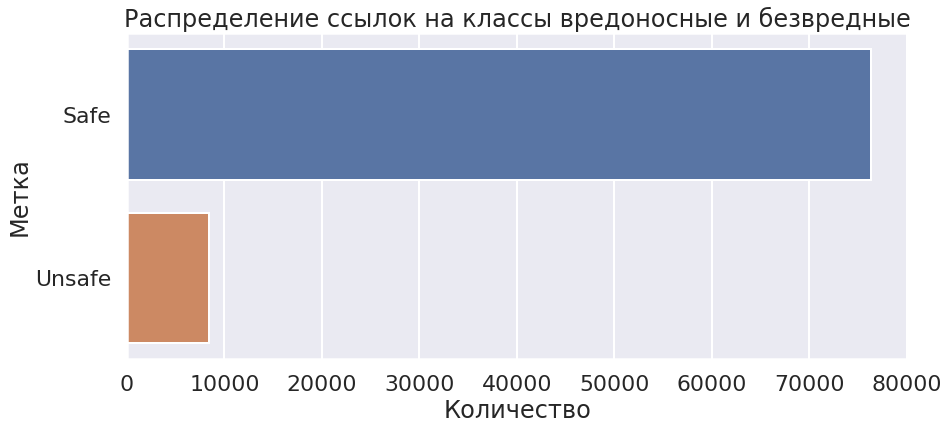

In [10]:
sns.set_context('poster')
plt.figure(figsize=(14, 6))
ax = sns.countplot(y='label', data=data)
ax.set(xlabel ='Количество', ylabel ='Метка', 
       title ='Распределение ссылок на классы вредоносные и безвредные');

Явно выраженный дисбаланс классов: безвредных ссылок примерно в 9 раз больше.

## Разделение данных для обучения и тестирования

Если взять много данных для теста, то их совсем станет мало для обучения модели, но, с другой стороны, если взять мало данных для теста, то трудно будет узнать, на сколько модель обладает обобщающей способностью. Поэтому возьмем `30%` данных для теста. Также сделаем допущение, что распределение классов в датасете примерно отражает распределение классов в реальной жизни, поэтому в качестве последнего параметра функции `train_test_split` (`stratify`) передадим `data.label`. Таким образом, распределение классов будет одинаковым в обучающей и тестовой выборках.

In [11]:
from sklearn.model_selection import train_test_split

test_size = 0.3

train, test = train_test_split(
    data,
    test_size=test_size,
    random_state=RANDOM_SEED,
    stratify=data.label
)

## Кодирование целовой переменной

Так как нас в интересуют вредоносные URL-адреса, мы можем кодировать плохой класс `Unsafe` как положительный класс `1`, а хороший `Safe` - как отрицательный `0`. Это упрощает некоторые дальнейшие вычисления.

In [12]:
classes = ['Safe', 'Unsafe']

y_train = train['label'].apply(lambda label: classes.index(label))
y_test = test['label'].apply(lambda label: classes.index(label))

## "Dummy" базовая модель

Моделирование лучше всего начинать с самой простой из возможных моделей. Это не решение проблемы, а скорее позволяет оценить нижнюю границу возможной производительности модели.

Одной из таких моделей является присвоение случайной метки (`0` или `1`) с вероятностью, оцениваемой по распределению классов в обучающем наборе.

В качестве признаков мы можем просто использовать нули.

In [13]:
X_train_zero = np.zeros((len(train), 1))
X_test_zero = np.zeros((len(test), 1))

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_SEED, 
).fit(X_train_zero, y_train)

In [15]:
y_pred_dummy = dummy_clf.predict(X_test_zero)

Распространенной ошибкой при работе с несбалансированными классами является выбор неадекватной оценочной метрики, которая допускает слишком большое усреднение. Например, поскольку существует много отрицательных `0` экземпляров, доля правильных ответов будет искажена.

In [16]:
from sklearn.metrics import accuracy_score

dummy_acc = accuracy_score(y_test, y_pred_dummy)
print("Доля правильных ответов Dummy классификатора: {:5f}".format(dummy_acc))

Доля правильных ответов Dummy классификатора: 0.819397


Чтобы лучше понять проблему, мы можем построить матрицу неточностей.

In [17]:
from sklearn.metrics import confusion_matrix

dummy_cnf_mat = confusion_matrix(y_test, y_pred_dummy)

In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Метрица неточностей',
                          cmap=plt.cm.Blues):
    """
    Данная функция печатает и строит матрицу неточностей.
    Нормализация может применяться при установке нормализуют=правда`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set_context('poster')
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказанное значение')
    plt.tight_layout()
    plt.grid(None)

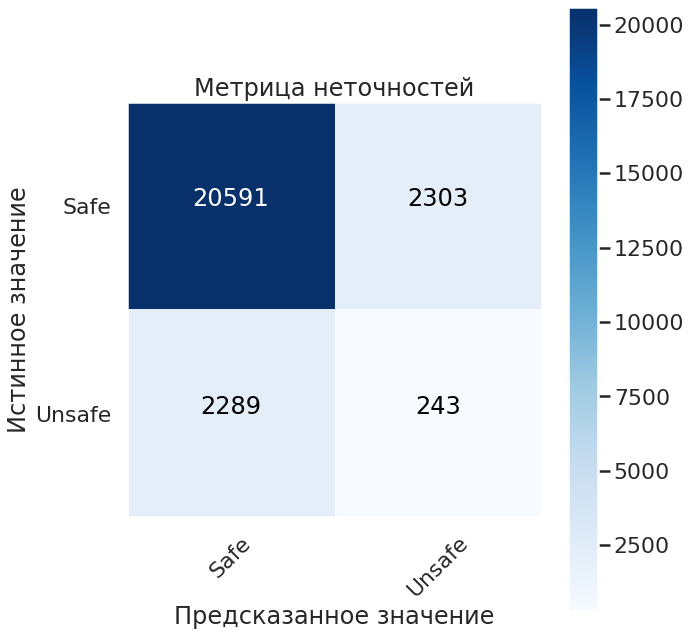

In [19]:
plot_confusion_matrix(
    dummy_cnf_mat,
    classes,
)

Матрица неточностей ясно показывает, что число ложных срабатываний и ложных отрицаний намного больше, чем число истинных срабатываний для плохого класса.

Чтобы формализовать эту пропорцию, рассмотрим следующие бинарные классификационные метрики:

1. Precision

$$
P = \frac{TP}{TP + FP}
$$

2. Recall

$$
R = \frac{TP}{TP + FN}
$$

3. F-measure, a harmonic mean of precision and recall

$$
F_1 = \frac{2PR}{P + R}
$$

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

dummy_precision = precision_score(y_test, y_pred_dummy)
dummy_recall = recall_score(y_test, y_pred_dummy)
dummy_f1 = f1_score(y_test, y_pred_dummy)

print("Dummy classifier metrics:")
print("\tP:  {:5f}".format(dummy_precision))
print("\tR:  {:5f}".format(dummy_recall))
print("\tF1: {:5f}".format(dummy_f1))

Dummy classifier metrics:
	P:  0.095444
	R:  0.095972
	F1: 0.095707


Эти метрики, принимающие значения от 0 до 1, ясно показывают, что "Dummy" классификатор является плохим решением, которое может быть использовано только для оценки нижней границы производительности. Любой реальный классификатор должен превзойти "Dummy" решение.

Мы можем увидеть, как такие показатели, как точность, влияют на дисбаланс классов, если мы рассчитаем их для каждого класса:

In [21]:
from sklearn.metrics import classification_report

dummy_clf_report = classification_report(
    y_test,
    y_pred_dummy,
    target_names=classes,
)
print(dummy_clf_report)

              precision    recall  f1-score   support

        Safe       0.90      0.90      0.90     22894
      Unsafe       0.10      0.10      0.10      2532

    accuracy                           0.82     25426
   macro avg       0.50      0.50      0.50     25426
weighted avg       0.82      0.82      0.82     25426



Усреднение метрик дает результат `0.82`

## Извлечение признаков и их анализ 

Для экспериментов и анализа создадим копию обучающей выборки.

In [22]:
train_copy = train.copy()

### Анализ длины `url`

Посмотрим на топ 50 длин `url` в данной обучающей выборке.

In [23]:
train_copy['url_len'] = train['url'].apply(lambda x: len(x))
train_copy['url_len'].value_counts().head(50)

13     4459
12     4400
14     4264
11     4159
15     4057
10     3836
16     3543
17     3176
9      3062
18     2759
19     2437
20     1985
8      1862
21     1566
22     1363
7      1121
23     1093
24      921
6       646
25      645
26      503
27      411
28      364
29      257
30      223
31      195
32      183
47      163
33      161
34      135
36      127
39      112
46      108
38      106
35      105
37      102
5       102
42       96
41       95
40       93
44       93
50       88
58       87
49       84
43       81
53       80
45       78
57       76
447      74
55       72
Name: url_len, dtype: int64

Чаще всего встречаются `url`, длина который меньше 50.  Посмотрим, как взаимосвязаны длина `url` и значение целевой метки, при этом ограничимся `url` с длиной меньше или равной 50. 

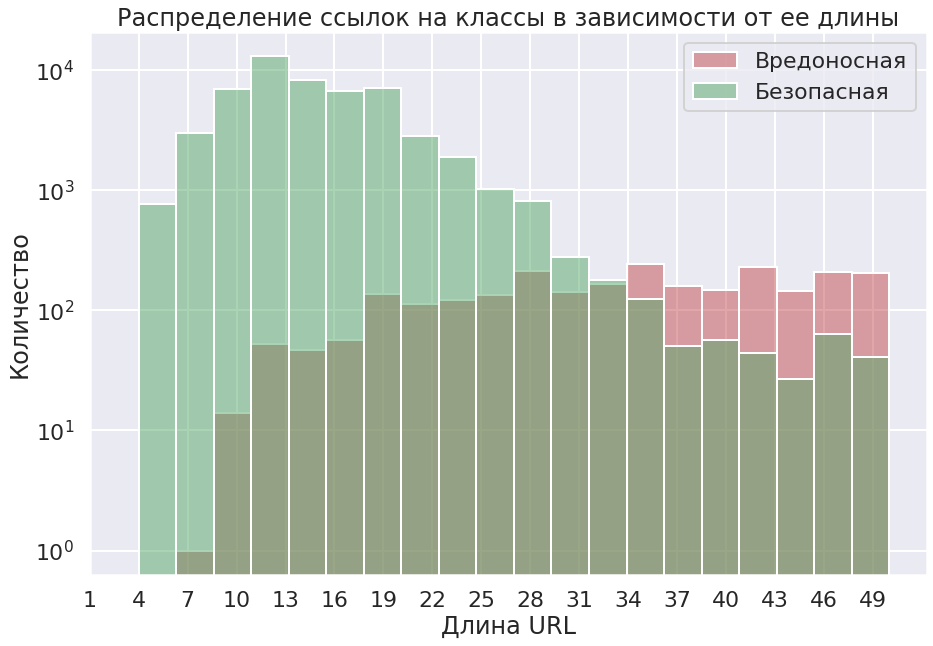

In [24]:
sns.set_context('poster')
plt.figure(figsize=(15, 10))
mask = train_copy['url_len'] <= 50

ax = sns.histplot(data=train_copy[mask], x='url_len', hue='label', bins=20, 
                  palette=['g', 'r'])
ax.set(xlabel='Длина URL', ylabel ='Количество', 
       title ='Распределение ссылок на классы в зависимости от ее длины')
plt.legend(labels=['Вредоносная', 'Безопасная'])
plt.yscale('log')
plt.xticks(np.arange(1, 51, 3));

На графике четко видно, что при чем длинее `url`, тем больше вероятность того, что ссылка является вредоносной. Поэтому данный признак необходимо будет добавить в выборки.

### Парсер URL

В url содержится много полезной информации, которую нужно аккуратно извлечь. Для этого воспользуемся функцией `urlparse` и дополнительно выделим еще больше информации.

In [25]:
from urllib.parse import urlparse

def get_url_info(url):
    # парсим исходную url
    parse_res = urlparse(url)
    # извлекаем схему url (сетевой протокол)
    scheme = parse_res.scheme
    # извлекаем имя хоста url
    netloc = parse_res.netloc
    # извлекаем url-путь 
    path = parse_res.path
    # исправляем ошибки urlparse
    if not netloc:
        netloc = path
        path = ''
    if netloc.count('/'):
        path = '/' + netloc.split('/', 1)[1] if not path else path
        netloc = netloc.split('/', 1)[0]
    # извлекаем домен первого уровня
    top_lvl_domain = netloc.split('.')[-1]
    # считаем длину url-пути
    path_len = path.count('/')
    # содержит ли url запрос
    contain_query = int(bool(parse_res.query))
    # считаем количество уникальных символов url
    unique_char_num = len(set(url))
    return scheme, netloc, top_lvl_domain, path, path_len,\
           contain_query, unique_char_num

new_features = np.array([train_copy['url'].apply(get_url_info)])\
                       .reshape(len(train_copy), 7)

new_features_name = ['scheme', 'netloc', 'top_lvl_domain', 'path', 'path_len',
                     'contain_query', 'unique_char_num']
for i in range(7):
    train_copy[new_features_name[i]] = new_features[:, i]

#### Схема

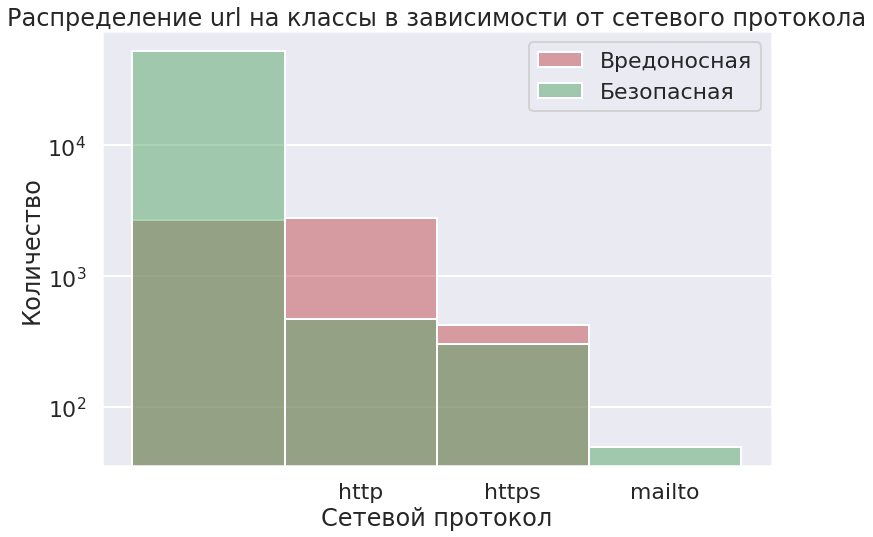

In [26]:
sns.set_context('poster')
plt.figure(figsize=(12, 8))

ax = sns.histplot(data=train_copy, x='scheme', hue='label', palette=['g', 'r'])
ax.set(xlabel='Сетевой протокол', ylabel ='Количество', 
       title ='Распределение url на классы в зависимости от сетевого протокола')
plt.legend(labels=['Вредоносная', 'Безопасная'])
ax.xaxis.grid(None)
plt.yscale('log')

Если `url` в явном виде содержит сетевой протокол, то, скорее всего, она вредоносная. Исключением является сетевой протокол `mailto`. Все url, которые содержат явно данный протокол, являются безвредными. `mailto`* определяет схему для адресов электронной почты в SMTP.

\* [mailto Википедия](https://ru.wikipedia.org/wiki/Mailto)

#### Домен 1-го уровня

Посмотрим на влияние домена на класс url. Возьмем первые 50 по популярности доменов 1-го уровня. 

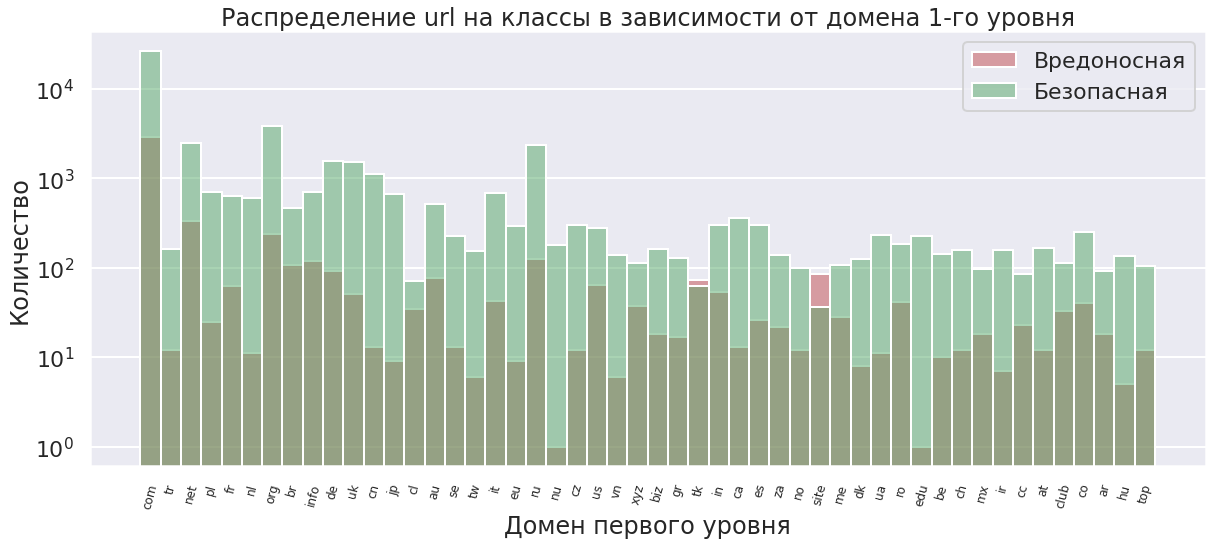

In [27]:
sns.set_context('poster')
plt.figure(figsize=(20, 8))
top50_lvl_domains = train_copy.top_lvl_domain.value_counts()[:50].index
mask = train_copy.top_lvl_domain.apply(lambda x: x in top50_lvl_domains)

ax = sns.histplot(data=train_copy[mask], x='top_lvl_domain', hue='label', 
                  palette=['g', 'r'])
ax.set(xlabel='Домен первого уровня', ylabel ='Количество', 
       title ='Распределение url на классы в зависимости от домена 1-го уровня')
plt.legend(labels=['Вредоносная', 'Безопасная'])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    tick.label.set_rotation(75)
ax.xaxis.grid(None)
plt.yscale('log')

Только для двух доменов вероятность того, что url будет вредоносная, выше.

#### Длина url-пути

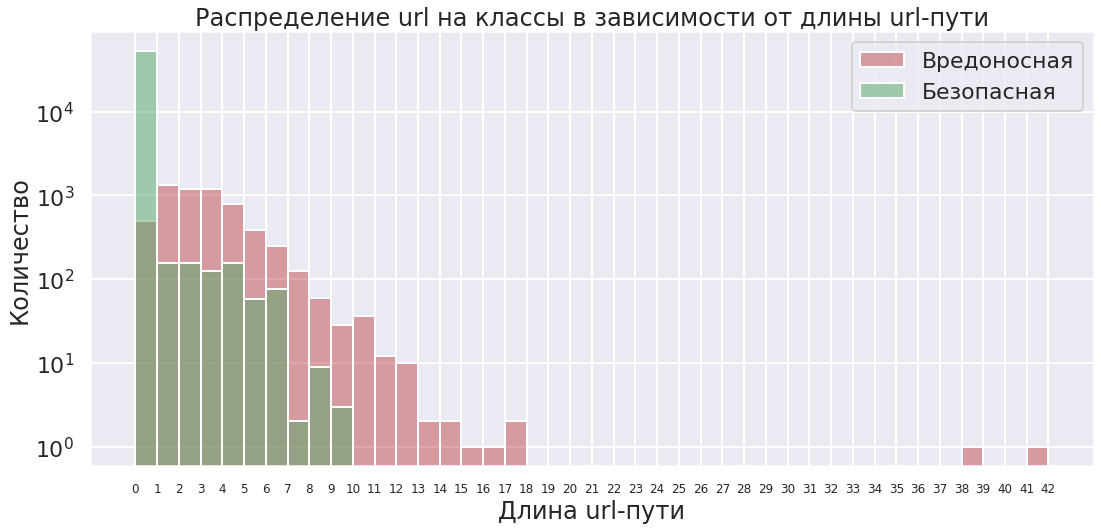

In [28]:
sns.set_context('poster')
plt.figure(figsize=(18, 8))

ax = sns.histplot(data=train_copy, x='path_len', hue='label', bins=42,
                  palette=['g', 'r'])
ax.set(xlabel='Длина url-пути', ylabel ='Количество', 
       title ='Распределение url на классы в зависимости от длины url-пути')
plt.legend(labels=['Вредоносная', 'Безопасная'])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
# ax.xaxis.grid(None)
plt.yscale('log')
plt.xticks(np.arange(0, 43, 1));

Те url, которые имеют не нулевой url-путь, чаще оказываются вредоносными.

#### url запрос

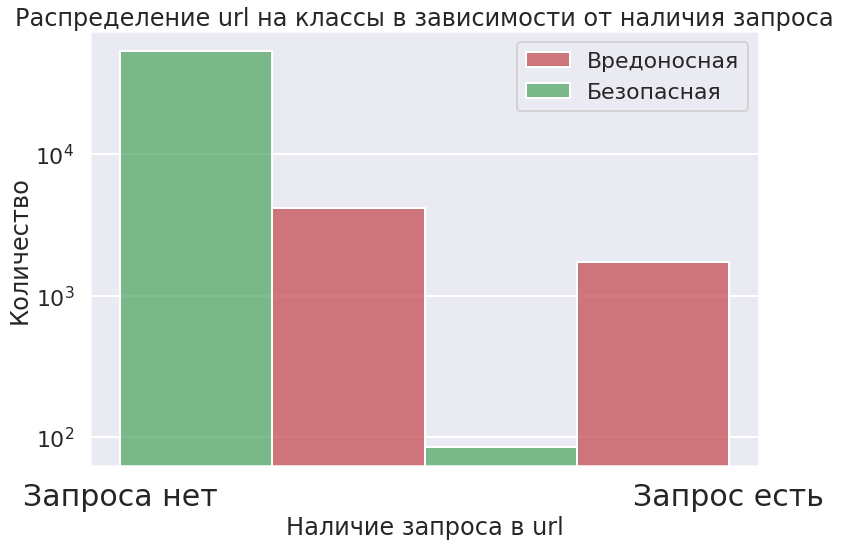

In [155]:
sns.set_context('poster')
plt.figure(figsize=(12, 8))

ax = sns.histplot(data=train_copy, x='contain_query', hue='label', bins=2, 
                  palette=['g', 'r'], multiple='dodge')
ax.set(xlabel='Наличие запроса в url', ylabel ='Количество', 
       title ='Распределение url на классы в зависимости от наличия запроса')
plt.legend(labels=['Вредоносная', 'Безопасная'])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax.xaxis.grid(None)
plt.yscale('log')
plt.xticks(range(2), ['Запроса нет', 'Запрос есть']);

Получился хороший бинарный признак.

#### Количество уникальных символов

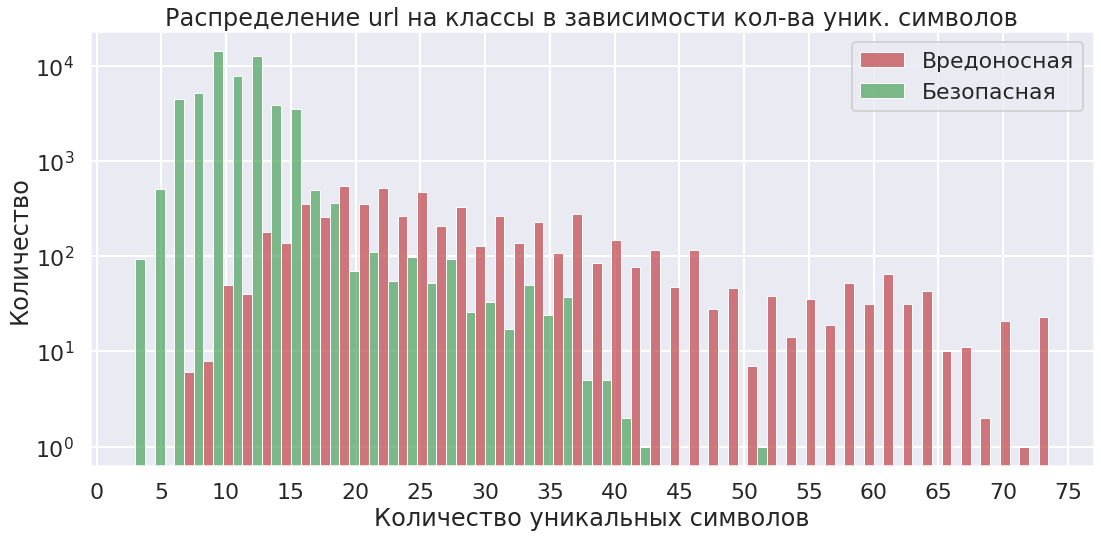

In [156]:
sns.set_context('poster')
plt.figure(figsize=(18, 8))

ax = sns.histplot(data=train_copy, x='unique_char_num', hue='label', shrink=1,
                  palette=['g', 'r'], multiple='dodge', binwidth=3/2)
ax.set(xlabel='Количество уникальных символов', ylabel ='Количество', 
       title ='Распределение url на классы в зависимости кол-ва уник. символов')
plt.legend(labels=['Вредоносная', 'Безопасная'])
plt.yscale('log')
plt.xticks(np.arange(0, 76, 5));

Безопасные url содержат меньше уникальных символов, чем вредоносные.

### Вектора слов

Извлечем все слова из имени домена и пути и составим из них вектора.

In [31]:
train_copy['words'] = train_copy.netloc.apply(lambda x: ' '.join(x.split('.'))) +\
                      train_copy.path.apply(lambda x: ' '.join(x.split('/')) if x else '')

Обучим `CountVectorizer` на получившихся предложениях.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(
    min_df=0.0005
).fit(train_copy['words'])

In [33]:
len(word_vectorizer.get_feature_names())

233

Получилось еще 233 новых признака. Посмотрим, сколько в сумме каждый встречается из них в тренировочном датасете.

In [34]:
np.sum(word_vectorizer.transform(train_copy['words']), axis=0)

matrix([[  101,    89,    39,   108,    63,   204,    89,   149,    40,
            55,    53,    55,   119,    37,    95,    35,   194,   609,
            54,    32,   161,    34,   183,    99,    48,   169,    71,
           590,    73,    77,   395,   115,    60,   121,   180,    39,
            42,    35,   116,    54,   164,    44,  1161,  2308, 31952,
            34,   206,    30,    74,    62,    56,    32,   316,    33,
          1764,    30,    71,   139,    36,    48,    54,   150,   190,
            80,   460,    31,    41,    78,   347,   319,    36,    88,
            42,    65,    37,   761,    42,    60,    38,   119,   168,
           590,    37,   155,    61,   115,    46,   181,   540,   144,
           145,    97,    76,    55,   174,    37,   424,   221,   377,
           920,    35,    49,   103,   167,    35,   755,    49,   691,
           109,   101,    96,    54,    45,    95,   106,    35,    95,
            37,    51,    44,    38,    90,   495,    57,    33,

Посмотрим на 10 слов.

In [35]:
from pprint import pprint

np.random.seed(RANDOM_SEED)
pprint(np.random.choice(word_vectorizer.get_feature_names(), 10), compact=True)

array(['security', 'thebookreportnetwork', 'blogspot', 'en', 'uploads',
       'online', 'ir', 'il', 'space', 'ng'], dtype='<U20')


### N-граммы

 Добавим в нашу обучающую выборку  N-граммы букв от 1 до 4

In [36]:
ngram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=(1, 4),
    min_df=0.001,
).fit(train_copy['url'])

In [37]:
len(ngram_vectorizer.get_feature_names())

6944

Добавилось еще `6944` признака. Посмотрим на 100 случайных N-грамм.

In [38]:
from pprint import pprint

np.random.seed(RANDOM_SEED)
pprint(np.random.choice(ngram_vectorizer.get_feature_names(), 100), compact=True)

array(['n.h', 'afar', '/vie', 'er/', 's3', 'nab', '8f', 'say', 'andi',
       'ici', 'erma', 'kas', 'ngl', 'nig', 'wil', 'fe.', 'own', 'ibu',
       'teri', '_su', 'arma', 't.r', '/5', 'prin', 'g-', 'eand', 'ison',
       'hio', 'lad', 'an', 'lit', 'aced', 'n.or', 'gor', 'oom', 'm.tw',
       'nec', '.s', 'u.cn', 'rsp', 'who', '44', 'vy', 'abs', 'afa', 'p1a',
       '.hu', 'bus', 'em', 'tage', 'rk.', 'go.c', 'x-', '418', 's:',
       'um.c', 'fh', 'fro', 'rs-', 'rich', 'ro-', 'r.n', '-de', 'ooks',
       'agu', 'bn', 'ehe', '92', 'vo', 'esc', 'rbo', 'nty', 'pl%', '4l',
       '&s', 'hz', 'rest', 'yri', 'ci', 'pc', 'tei', 't.r', 'arde', 'qw',
       'pros', 'm.d', 'nn', 'tica', 'sco', 'kai', 'u.e', 'tbal', '--',
       '4h', 'wate', '.z', 'do.c', 'nl.d', '68', 'sub'], dtype='<U4')


## Добавление признаков

Я считаю, что мы сформировали достаточное количество признаков. Тепеhь необходимо написать функцию, которая вернет окончательный тренировочный и тестовый наборы данных.

In [39]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack

In [45]:
def get_train_test_features(train, test):

    # копируем данные, чтобы не изменять исходные
    train = train.copy()
    test = test.copy()

    # добавляем функцию, которая превращает длину ссылки в категорию
    def _cat_url_len(url):
        url_len = len(url)
        if url_len < 10:
            return 'short'
        elif url_len >= 10 and url_len < 30:
            return 'medium'
        elif url_len >= 30 and url_len < 50:
            return 'long'
        else:
            return 'extremely_long'
    
    # добавляем длину ссылки в виде категории
    train['cat_url_len'] = train['url'].apply(lambda x: _cat_url_len(x))
    test['cat_url_len'] = test['url'].apply(lambda x: _cat_url_len(x))

    # имена новых признаков
    new_features_names = ['scheme', 'netloc', 'top_lvl_domain', 'path',
                         'path_len', 'contain_query', 'unique_char_num']

    # создаем матрицу новых признаков
    new_features_train = np.array([train['url'].apply(get_url_info)])\
                                 .reshape(len(train), len(new_features_names))
    new_features_test = np.array([test['url'].apply(get_url_info)])\
                                 .reshape(len(test), len(new_features_names))

    # добавляем новые признаки
    for i in range(len(new_features_names)):
        train[new_features_name[i]] = new_features_train[:, i]
        test[new_features_name[i]] = new_features_test[:, i]
    
    # формируем текст из слов на основе домена и пути
    train['words'] = train.netloc.apply(lambda x: ' '.join(x.split('.'))) +\
                train.path.apply(lambda x: ' '.join(x.split('/')) if x else '')
    test['words'] = test.netloc.apply(lambda x: ' '.join(x.split('.'))) +\
                test.path.apply(lambda x: ' '.join(x.split('/')) if x else '')

    # преобразуем слова в вектора
    word_vectorizer = CountVectorizer(
        min_df=0.0005
    ).fit(train['words'])

    # преобразуем url в N-граммы
    ngram_vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(1, 4),
        min_df=0.001,
    ).fit(train['url'])

    # закодируем некоторые признаки
    features_for_enc = ['scheme', 'path_len', 'unique_char_num', 'cat_url_len']
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(train[features_for_enc])
    # формируем окончательные данные

    train = hstack([csr_matrix(train[['contain_query']].values.astype(float)),
                    enc.transform(train[features_for_enc]), 
                    word_vectorizer.transform(train['words']),
                    ngram_vectorizer.transform(train['url'])])
    
    test = hstack([csr_matrix(test[['contain_query']].values.astype(float)),
                   enc.transform(test[features_for_enc]), 
                   word_vectorizer.transform(test['words']),
                   ngram_vectorizer.transform(test['url'])])
    
    return train, test

In [46]:
%%time

X_train, X_test = get_train_test_features(train, test)

CPU times: user 8.34 s, sys: 77.8 ms, total: 8.42 s
Wall time: 8.42 s


Данную функцию наверняка можно оптимизировать так, чтобы было меньше задействовано памяти и была большая скорость выполнения.

Проверим размерности данных.

In [48]:
print(f'Размерность тренировочных данных: {X_train.shape}\
        \nРазмерность тестовых данных: {X_test.shape}')

Размерность тренировочных данных: (59325, 7277)        
Размерность тестовых данных: (25426, 7277)


## Обучение моделей

Определим функцию, которая будет рисовать ROC-AUC.

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_true, y_pred, ax=None, pos_label=None, **kwargs):
    """
    Plot multiple PR curves on same figure

    Parameters:
    ----------
    y_true: array, shape = [n_samples]
          True targets of binary classification in range {-1, 1} or {0, 1}.
    probas_pred : array, array shape = [n_samples]
                Estimated probabilities or decision function.
    pos_label : int or str, default=None
              The label of the positive class

    ax: matplotlib.axes, default=None
       Axes to plot on. If None - creates a new figure

    kwargs: additional args to ax.plot
    """

    sns.set_context('poster')
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=pos_label)

    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1,1,1)

    ax.step(fpr, tpr, where='post', **kwargs)
    ax.plot([0, 1], [0, 1], linestyle='--', color='k')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')

### Логистическая регрессия

Данный алгоритм является разумным первым выбором для быстрого получения нетривиального решения.

Давайте обучим модель с помощью этого алгоритма с параметрами по умолчанию.

In [50]:
%%time

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)

CPU times: user 1.6 s, sys: 14 ms, total: 1.62 s
Wall time: 1.68 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Теперь мы можем получить прогнозы для тестового набора.

In [51]:
y_pred_logreg = logreg.predict(X_test)

Ниже приведены оценочные показатели для обоих классов:

In [52]:
logreg_clf_report = classification_report(y_test, y_pred_logreg,
                                          target_names=classes)
print(logreg_clf_report)

              precision    recall  f1-score   support

        Safe       0.99      1.00      0.99     22894
      Unsafe       0.97      0.93      0.95      2532

    accuracy                           0.99     25426
   macro avg       0.98      0.96      0.97     25426
weighted avg       0.99      0.99      0.99     25426



По сравнению с базовой моделью эта модель показывает гораздо лучшие результаты для положительного (плохого) класса, а также и для отрицательного (хорошего) класса.

В отличие от `Dummy` алгоритма, логистическая регрессия также оценивает вероятности классов.

Поскольку мы решаем бинарную классификационную модель, мы учитываем только вероятности положительного (1) класса.

In [53]:
y_pred_proba_logreg = logreg.predict_proba(X_test)[:, 1]

Мы также можем рассмотреть кривую ROC-AUC

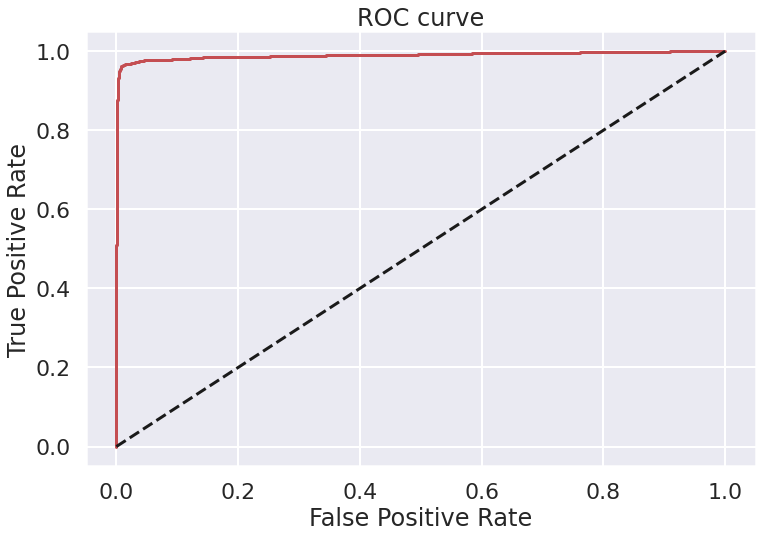

In [54]:
plot_roc_curve(y_test, y_pred_proba_logreg, color='r')

In [55]:
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
print("Logistic Regression ROC-AUC: {:5f}".format(logreg_roc_auc))

Logistic Regression ROC-AUC: 0.990127


Сразу же получилось отлично качество модели. Но все-таки попробуем его улучшить. Посмотрим, подходит ли вообще линейная модель. Логистическая регрессия является линейным методом классификации и может обеспечить хорошую производительность только в том случае, если классы линейно разделимы в пространстве признаков.

In [56]:
from sklearn.decomposition import TruncatedSVD

def plot_classes(X, classes, **kwargs):
    plt.figure(figsize=(12, 8))
    X_test_char_reducted = TruncatedSVD(n_components=2).fit_transform(X)
  

    x = X_test_char_reducted[:, 0]
    y = X_test_char_reducted[:, 1]
  
    xlim = (np.percentile(x, 1),
            np.percentile(x, 99.5))
    ylim = (np.percentile(y, 1),
            np.percentile(y, 99.5))
 
    plt.scatter(
        x,
        y,
        c=classes,
        **kwargs,
    )
  
    plt.tick_params(
        axis='both',          
        which='both', 
        bottom=False,
        labelbottom=False,
        labelleft=False,
    )
    plt.xlim(xlim)
    plt.ylim(ylim)

Посмотрим на проекцию экземпляров на 2D с помощью метода анализа главных компонент (PCA).

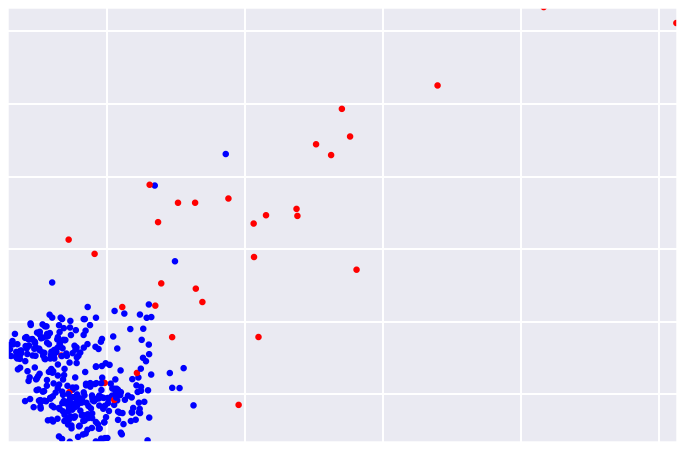

In [58]:
num_objs_to_plot = 400

from matplotlib.cm import bwr

np.random.seed(RANDOM_SEED)
idx_to_plot = np.random.choice(
    np.arange(len(test)),
    num_objs_to_plot
)

plot_classes(
    X_test.tocsr()[idx_to_plot, :],
    y_test.iloc[idx_to_plot],
    cmap=bwr,
    s=20
)

Проекция показывает, что классы немного смешиваются в этом пространстве объектов, и мы должны либо использовать нелинейную модель, либо изменить пространство объектов. Воспользуемся нелинейной моделью.

### XGBoost

Градиентный бустинг дает возможность найти лучшую модель путем настройки различных гиперпараметров алгоритма.

Во время гиперпараметрического поиска легко переобучиться, поэтому нам нужен более глубокий подход к оценке, такой как кросс-валидация по нескольким выборкам обучающего набора. Среднее значение и дисперсия оценочных метрик позволяют оценить, как изменения производительности, вызванные различными гиперпараметрами, соотносятся со случайными изменениями, вызванными особенностями тестовых выборок.

Определим искомую метрику

In [67]:
def grid_score(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, y_pred)

В общем, есть два способа, с помощью которых мы можем управлять переобучением в XGBoost:

1.   Первый способ - это непосредственное управление сложностью. За это отвечают параметры:
    *   `max_depth` **[default=6]** - Максимальная глубина дерева. Увеличение данного параметра сделает модель более сложной и более склонной к переобучению.
    *   `min_child_weight` **[default=1]** - Минимальная сумма веса экземпляра, необходимая поддереву. Если шаг разбиения дерева приводит к листовому узлу с суммой веса экземпляра меньше `min_child_weight`, то процесс построения откажется от дальнейшего разбиения.
    *   `gamma` **[default=0]** - Минимальное уменьшение потерь, которе требуется для того, чтобы сделать дальнейшее разбиение на листовой узел дерева. Чем больше гамма, тем более консервативным будет алгоритм.


2.   Второй способ - добавить случайность, чтобы сделать обучение устойчивым к шуму. За это отвечают параметры:
    *   `subsample` **[default=1]** - Соотношение подвыборок обучающих экземпляров. Установка его равным 0.5 означает, что XGBoost будет случайным образом отбирать половину обучающих данных до выращивания деревьев. и это предотвратит переобучение.
    *   `eta` **[default=0.3]** - Размера шага, используемого в обновлении весов для предотвращения переобучения. 



In [99]:
grid_params = {
  'max_depth': [5, 15, 25],
  'min_child_weight': [1, 4, 8],
  'gamma': [0, 1, 2],
  'subsample': [0.5, 0.8, 1],
  'eta': [0.1, 0.3, 0.5]
}

In [102]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=10,
    objective='binary:logistic',
    silent=True,
    n_jobs=-1,
    seed=RANDOM_SEED
)

skf = StratifiedKFold(n_splits=3)

scorer = make_scorer(grid_score)

grid_search = GridSearchCV(
    xgb_clf,
    param_grid=grid_params,
    scoring=scorer,
    cv=skf,
    verbose=1,
    refit=False,
)

In [103]:
%%time

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1h 16min 44s, sys: 27.1 s, total: 1h 17min 11s
Wall time: 44min 7s


[Parallel(n_jobs=1)]: Done 729 out of 729 | elapsed: 44.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=-1,
                                     nthread=None, objective='binary:...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=7, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.1, 0.3, 0.5], 'gamma': [0, 1, 2],
                         'max_depth': [5, 15,

Лучшие гиперпараметры для xgb

In [104]:
grid_search.best_params_

{'eta': 0.1,
 'gamma': 0,
 'max_depth': 25,
 'min_child_weight': 1,
 'subsample': 0.8}

Давайте переобучим модель градиентного бустинга, используя обнаруженные гиперпараметры. При этом будем обучать на всей выборке. Также увеличим количество деревьев до 400.

In [107]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=400,
    objective='binary:logistic',
    silent=True,
    n_jobs=-1,
    seed=RANDOM_SEED,
    **grid_search.best_params_
)

In [108]:
%%time 

xgb_clf.fit(X_train, y_train)

CPU times: user 7min 38s, sys: 458 ms, total: 7min 39s
Wall time: 3min 54s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7,
              silent=True, subsample=0.8, verbosity=1)

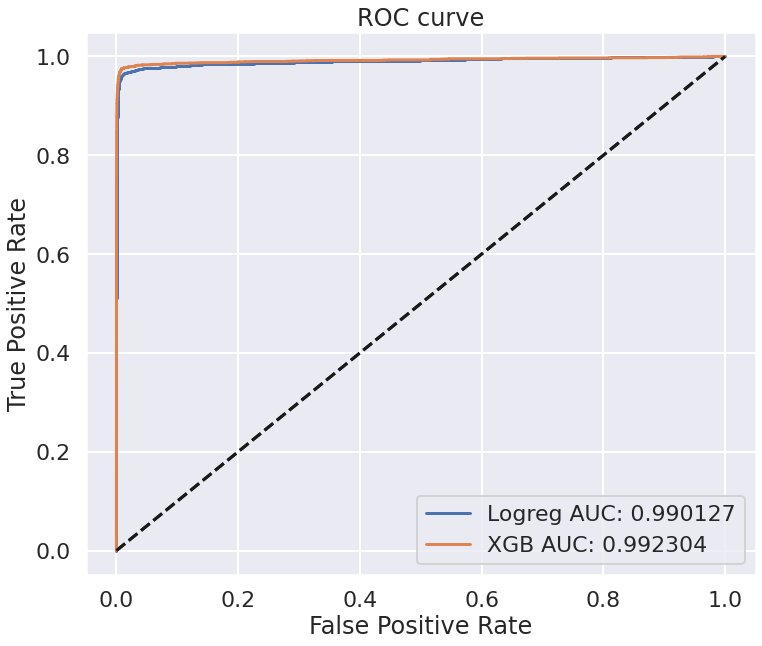

In [109]:
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

plot_roc_curve(
    y_test,
    y_pred_proba_logreg,
    ax=ax,
    label="Logreg AUC: {:5f}".format(logreg_roc_auc),
)
plot_roc_curve(
    y_test,
    y_pred_proba_xgb,
    ax=ax,
    label="XGB AUC: {:5f}".format(xgb_roc_auc),
)
ax.legend(loc=4);

In [111]:
print("XGBoost ROC-AUC: {:5f}".format(xgb_roc_auc))

XGBoost ROC-AUC: 0.992304


Качество стало лучше, но для этого было потрачено очень много времени. Легче попробовать подобрать гиперпараметры для логистической регрессии.

### Логичстическая регрессия - подбор параметра регуляризации С

Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).

С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression`

In [121]:
from sklearn.linear_model import LogisticRegressionCV

logit_c_values = np.logspace(-4, 2, 10)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values,
                                           random_state=RANDOM_SEED,
                                           cv=skf,
                                           n_jobs=-1,
                                           scoring=scorer)

In [122]:
%%time

logit_grid_searcher.fit(X_train, y_train)

CPU times: user 1.56 s, sys: 35 ms, total: 1.6 s
Wall time: 20.3 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                     tol=0.0001, verbose=0)

In [125]:
logit_mean_cv_scores = np.array(list(logit_grid_searcher.scores_.values()))\
                                .mean(axis = (0, 1))

In [134]:
best_score1 = np.amax(logit_mean_cv_scores)
best_C1 = logit_grid_searcher.Cs_[np.argmax(logit_mean_cv_scores)]

print(f'Лучшее среднее значение ROC-AUC: {best_score1} для С = {best_C1}')

Лучшее среднее значение ROC-AUC: 0.9589598332197671 для С = 1.0


Нарисуем график зависимости ROC-AUC score на кросс-валидации от `C`.

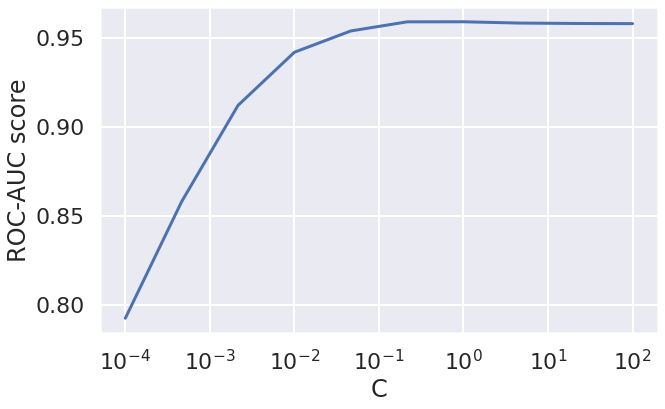

In [140]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values, logit_mean_cv_scores);

Теперь будем искать `C` в более узком диапазоне.

In [141]:
logit_c_values2 = np.linspace(0.1, 5, 40)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,
                                           random_state=RANDOM_SEED,
                                           cv=skf,
                                           n_jobs=-1,
                                           scoring=scorer)

In [143]:
%%time

logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 68.8 ms, total: 1.61 s
Wall time: 1min 40s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV(Cs=array([0.1       , 0.22564103, 0.35128205, 0.47692308, 0.6025641 ,
       0.72820513, 0.85384615, 0.97948718, 1.10512821, 1.23076923,
       1.35641026, 1.48205128, 1.60769231, 1.73333333, 1.85897436,
       1.98461538, 2.11025641, 2.23589744, 2.36153846, 2.48717949,
       2.61282051, 2.73846154, 2.86410256, 2.98974359, 3.11538462,
       3.24102564, 3.36666667, 3.49230769, 3.61794872, 3.74358974,
       3.86923077, 3.99487179, 4.12051282, 4.24615385, 4.37179487,
       4.4974359 , 4.62307692, 4.74871795, 4.87435897, 5.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                    

In [149]:
logit_mean_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values()))\
                                .mean(axis = (0, 1))

best_score2 = np.amax(logit_mean_cv_scores2)
best_C2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

print(f'Лучшее среднее значение ROC-AUC: {best_score2} для С = {best_C2}')

Лучшее среднее значение ROC-AUC: 0.959222915584197 для С = 0.8538461538461538


Нарисуем график зависимости ROC-AUC score на кросс-валидации от `C`.

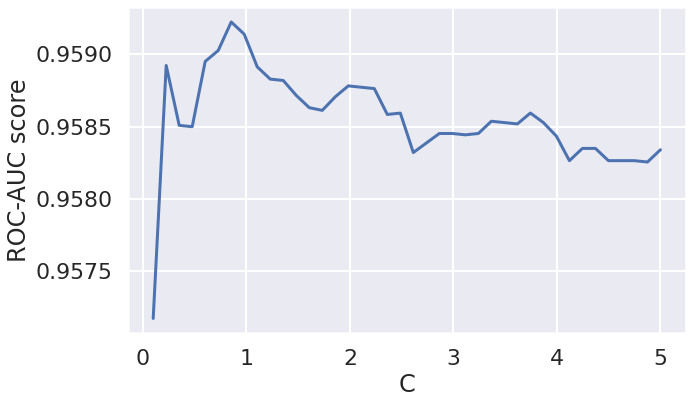

In [150]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Обучим логистическую регрессию на всей тренировочной выборке с лучшим значением C

In [151]:
%%time

logreg2 = LogisticRegression(C=best_C2,
                             random_state=RANDOM_SEED).fit(X_train, y_train)

CPU times: user 1.47 s, sys: 8.99 ms, total: 1.48 s
Wall time: 1.48 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [153]:
y_pred_proba_logreg2 = logreg2.predict_proba(X_test)[:, 1]
logreg_roc_auc2 = roc_auc_score(y_test, y_pred_proba_logreg2)

Сравним логистические регрессии между собой.

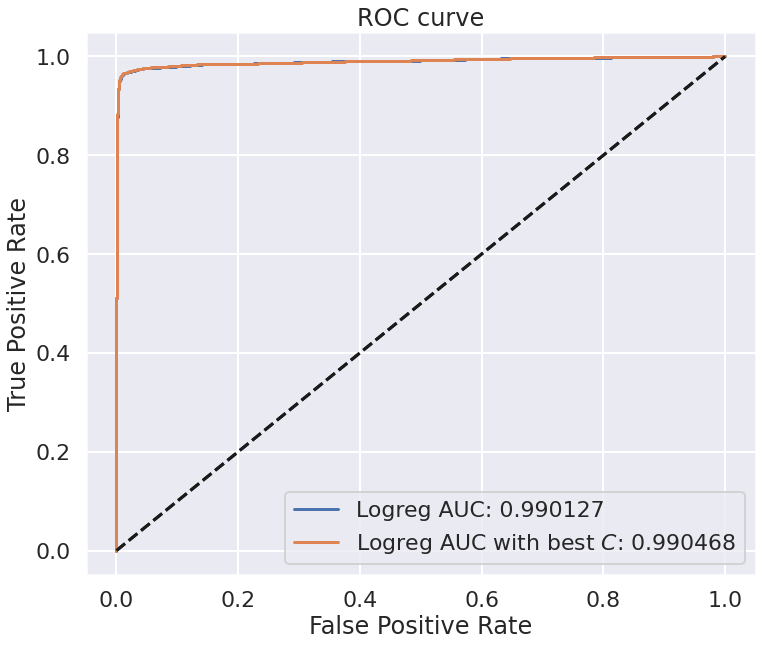

In [154]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

plot_roc_curve(
    y_test,
    y_pred_proba_logreg,
    ax=ax,
    label="Logreg AUC: {:5f}".format(logreg_roc_auc),
)
plot_roc_curve(
    y_test,
    y_pred_proba_logreg2,
    ax=ax,
    label="Logreg AUC with best $C$: {:5f}".format(logreg_roc_auc2),
)
ax.legend(loc=4);

Качество стало чуть-чуть лучше, но отличие только в 4 знаке после запятой.

## Вывод

Технологии машинного обучения __могут быть применимы__ в рамках решаемой задачи (детектирования вредоносных URL). При этом необходимо правильно __предобработать исходные данные__ и __извлечь__ из них максимальное количество информации для лучшей их работы и обобщающей способности. Извлечение признаков из 'сырого' датасета заняло примерно $8$ секунд. При этом размер датасета $84751$. Значит нам необходима $1$ секунда на каждые $10000$ примеров.

Лучшая модель для данной задачи - логистическая регрессия, так как она показывает большое значение `ROC-AUC` (`0.990468`) на тесте и при этом очень быстро обучается (`1.48 сек`). Все это необходимо для реального мира.